Importing the necessery libraries to read and manipulate the data and to use the Decision Tree model

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
import category_encoders as ce
from sklearn.model_selection import train_test_split
from io import StringIO
from IPython.display import Image  
import pydotplus
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

importing and separating the data into features and target, we removed 'Sex' since this categorical data is binary which might not result in good desicion tree

In [2]:
train_df = pd.read_csv("data//train_heart.csv")

x_types = ['Age','ChestPainType','RestingBP','Cholesterol','FastingBS','RestingECG','MaxHR','ExerciseAngina','Oldpeak','ST_Slope']

x = train_df[x_types]
y = train_df[['HeartDisease']]

fixing our non-numeric values in the data

In [3]:
ce_ord = ce.OrdinalEncoder(cols = ['ChestPainType','RestingECG','ExerciseAngina','ST_Slope'])
x = ce_ord.fit_transform(x)

splitting the training data to test for the efficiency of the model

In [4]:
x_train, x_test, y_train, y_true = train_test_split(x, y, random_state=104, test_size=0.2)

cleaning data from outliers using Isolation Forest

n_estimators: The number of trees in the forest. Increasing the number of trees can lead to a more robust estimate of the outliers, but it also increases computational cost.

max_samples: The number of samples to draw from the dataset to train each tree. Smaller values can lead to more diverse trees, which may be better at detecting outliers, but too small values might lead to underfitting.

contamination: The proportion of outliers expected in the dataset. Adjusting this hyperparameter is crucial as it affects the threshold for classifying points as outliers.

max_features: The number of features to consider when splitting a node. Adjusting this parameter can impact the diversity of the trees in the forest.

n_jobs: This parameter specifies the number of parallel jobs to run for building trees. If n_jobs is set to -1, it will use all available processors. Setting n_jobs to a higher value can speed up the training process by allowing multiple trees to be built simultaneously. However, setting it too high can lead to resource contention and degrade performance.

In [5]:
"""
ideas:
    - introduce quartile cleaning before or after Isolation forest
"""
# Isolation Forest for outlier detection
isolation_forest = IsolationForest(n_estimators=1000, contamination=0.1, max_features=4, random_state=42, n_jobs=5)
isolation_forest.fit(x_train, y_train)

# Predicting outliers
outlier_preds = isolation_forest.predict(x_train)
outliers_idx = [i for i, pred in enumerate(outlier_preds) if pred == -1]

# Removing outliers
x_train = np.delete(x_train, outliers_idx, axis=0)
y_train = np.delete(y_train, outliers_idx, axis=0)

creating and fitting the Decision tree model with our data. We set max depth to not overfit the model

n_estimators: The number of trees in the forest. Increasing this parameter generally improves performance until reaching a point of diminishing returns.

max_depth: The maximum depth of each tree in the forest. Increasing this parameter can lead to more complex models, potentially improving accuracy, but it also increases the risk of overfitting.

min_samples_split: The minimum number of samples required to split an internal node. Increasing this parameter can prevent overfitting by requiring a higher number of samples for a split.

min_samples_leaf: The minimum number of samples required to be at a leaf node. Increasing this parameter can also prevent overfitting by requiring each leaf to have a minimum number of samples.

In [6]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
"""
ideas:
    - increase min_samples_split and max_depth to increase complexity without overfiting
    - increase min_samples_leaf and max_depth to increase complexity without overfiting
"""
model = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=4, criterion="entropy")
model = model.fit(x_train, y_train)

c:\Users\matej\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


visualization of our Decision Tree

In [7]:
#dot_data = StringIO()
#export_graphviz(model, out_file = dot_data, filled = True, rounded = True, special_characters = True, feature_names = x_types, class_names=['no','yes'])
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#Image(graph.create_png(), width = 1500)

testing the model's efficiency by letting it predict on the unseen train data

In [8]:
y_test = model.predict(x_test)
y_true = np.array(y_true).flatten()
print(accuracy_score(y_true,y_test)*100, "%")

88.37209302325581 %


c:\Users\matej\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


confusion metrix to visualize the efficiency

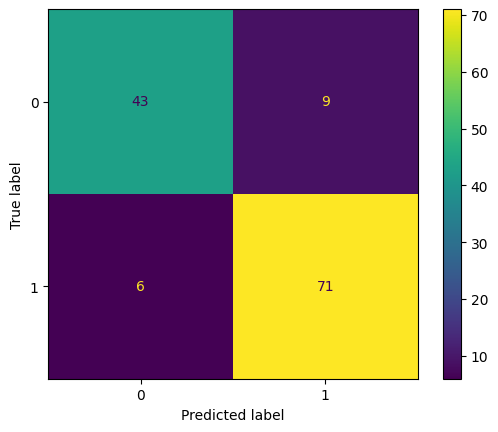

In [9]:
confusion_matrix(y_true, y_test)
ConfusionMatrixDisplay.from_predictions(y_true, y_test, labels=model.classes_)

making an actual prediction on the data for testing using our model

In [10]:
test_df = pd.read_csv("data//test_heart.csv")
test = test_df[x_types]
test = ce_ord.fit_transform(test)

prediction = model.predict(test)

out_df = pd.read_csv("data//sample_submission.csv")

for i,id in enumerate(out_df['id']):
    out_df['HeartDisease'][i] = prediction[i]

out_df.to_csv('output//outputIRF.csv', encoding='utf-8', index=False)

c:\Users\matej\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
